# Extract and clean the data

The data from the pdf will be stored as a list of dictionaries at stages.  

In [ ]:
import fitz  # PyMuPDF
import re

pdf_path = "constitution of India.pdf" # enter the path
doc = fitz.open(pdf_path)

# Step 1: raw extraction (all pages) with cleaning and metadata capture
pages_and_chunks_raw = []

for page_num in range(len(doc)):
    text = doc[page_num].get_text("text")
    
    # Remove unwanted lines: headers and standalone digits
    cleaned_lines = []
    for line in text.splitlines():
        stripped_line = line.strip()
        if not re.search(r"THE\s+CONSTITUTION\s+OF\s+INDIA", stripped_line, re.IGNORECASE) and not stripped_line.isdigit():
             cleaned_lines.append(line)
        # if _HEADER_RE.search(stripped_line):
        #     continue
        # if _STANDALONE_DIGITS_RE.match(stripped_line):
        #     continue
        # cleaned_lines.append(line)
    cleaned_text = "\n".join(cleaned_lines).strip()
    
    # Separate footnotes: look for a line of underscores (e.g., ________________) as separator
    lines = cleaned_text.splitlines()
    main_text_lines = []
    footnotes_lines = []
    in_footnotes = False
    separator_pattern = r'^[_]{5,}$'  # Matches lines with 5 or more underscores (adjust if needed)
    
    for line in lines:
        if re.match(separator_pattern, line.strip()):
            in_footnotes = True
            continue  # Skip the separator line itself
        if in_footnotes:
            footnotes_lines.append(line)
        else:
            main_text_lines.append(line)
    
    # Rebuild main text and footnotes
    main_text = "\n".join(main_text_lines).strip()
    f_notes = "\n".join(footnotes_lines).strip() if footnotes_lines else ""  # Empty if no footnotes
 
    # Now, extract "Section" metadata: look for pattern like "(...)" at the beginning (first few lines) of main_text
    section = ""  # Default to empty if not found
    main_lines = main_text.splitlines()[:5]  # Check only the beginning (first 5 lines)
    section_pattern = r"^\((.+?)\)$"  # Matches lines that are exactly "(content)"
    
    for line in main_lines:
        stripped = line.strip()
        match = re.match(section_pattern, stripped)
        if match:
            section = match.group(1).strip()  # Capture the text inside parentheses
            break  # Stop after finding the first match
    
    # If no match found, ignore (keep as empty) as per query
    
    # Store the page with cleaned main text, footnotes, and metadata
    pages_and_chunks_raw.append({
        "page_number": page_num + 1,
        "text": main_text,
        "section": section,
        "footnotes": f_notes  # Stored as metadata
    })

# Step 2: filter pages (skip 1–31 and 390–400). Please see the pdf for more info
pages_and_chunks= [
    item for item in pages_and_chunks_raw
    if item["page_number"] >= 32
    and not (390 <= item["page_number"] <= 400)
    and item["page_number"] != 142
]
doc.close()


In [25]:
'''this wont affect the section with just 1 page because as per the algorithm, empty section inherits the next section's value. 
since the next page after 1 page section is the first page of the new section, hence empty so the 1 page section inherits this emptiness'''

for i in range(len(pages_and_chunks)-2):  # Stop before the last two
        if not pages_and_chunks[i]["section"] :  # If empty ("" or falsy)
            # Fill from the next one
            pages_and_chunks[i]["section"] = pages_and_chunks[i + 1]["section"]
    


In [26]:
#get the remaining pages with section key empty
empty_pages = []
for item in pages_and_chunks:
        if not item.get("section", "").strip():  # Check if empty or whitespace-only
            empty_pages.append(item["page_number"])

empty_pages

[32, 56, 283, 401, 402]

In [27]:
pages_and_chunks[:2]

[{'page_number': 32,
  'text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'section': '',
  'footnotes': '1. Subs. by the Constitution (Forty-second Amendment) Act, 1976, s.2, for "SOVEREIGN \nDEMOCRATIC REPUBLIC" (w.e.f. 3-1-1977).\n2. Subs. by s. 2, ibid., for "Unity of the Nation" (w.e.f. 3-1-1977).'},
 {'page_number': 33,
  'text': 'PART I\nTHE UNION AND ITS TERRITORY\n1. Name and territory of the Union.—(1) India, that is Bharat, \nshall 

In [28]:
#since pages 1-32,142,390-400 were removed , need to subtract that many digits to get the current page numbers 
pages_and_chunks[401-11-32-1]["section"] ,pages_and_chunks[402-11-32-1]["section"]  ,pages_and_chunks[358-32-1]["section"] ,pages_and_chunks[341-32-1]["section"] 

('', '', 'Article 31B', 'Article 246')

In [29]:
# Example: Direct index assignment (if pages_and_chunks[0] is page 32) also we skipped pages 390 to 400 so do the math to get exact page numbers
pages_and_chunks[0]["section"] = "Preamble"  # Page 32
pages_and_chunks[24]["section"] = "PART IVA FUNDAMENTAL DUTIES"  # Page 56
pages_and_chunks[250]["section"] = "PART XXII SHORT TITLE, COMMENCEMENT, AUTHORITATIVE TEXT IN HINDI AND REPEALS"  # Page 283
pages_and_chunks[308]["section"] = 'Seventh Schedule' 
pages_and_chunks[325]["section"] = 'Ninth Schedule'
pages_and_chunks[347]["section"] = 'Eleventh Schedule'
pages_and_chunks[348]["section"] = 'Twelfth Schedule'
pages_and_chunks[357]["section"] = "APPENDIX II"  # Page 401
pages_and_chunks[358]["section"] = "APPENDIX III"  # Page 402


## Tokenizer

In [30]:
from transformers import AutoTokenizer
TOK = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-mpnet-base-dot-v1")

def count_tokens(text: str) -> int:
    # add_special_tokens ensures model-realistic length
    return len(TOK.encode(text, add_special_tokens=True))


## Section split and consolidation

Split the constitution into different sections based on the parts and consolidate the text under each part .

In [31]:
# pages_and_chunks is a list of dicts with keys 'page_number', 'text', 'section'
# Create a dictionary to hold consolidated text by section
consolidated_sections = {}

# Temporary variable to build text for each group
current_section = None
current_text = []
current_page_numbers = []
current_footnotes = {}  # Will be a dict of {page_number: footnotes}

# Iterate through the list of dictionaries (sorted by page_number)
for page in pages_and_chunks:
    section = page['section'].strip()  
    
    if section != current_section:
        # Save the previous group if it exists
        if current_section is not None:
            consolidated_sections[current_section] = {
                "consolidated_text": "\n".join(current_text).strip(),
                "page_numbers": current_page_numbers,  # List of page numbers for this section
                "footnotes": current_footnotes  # Dict of footnotes keyed by page_number
            }
        
        # Start new group
        current_section = section
        current_text = [page['text']]
        current_page_numbers = [page['page_number']]
        current_footnotes = {page['page_number']: page['footnotes']}
    else:
        # Append to current group
        current_text.append(page['text'])
        current_page_numbers.append(page['page_number'])
        current_footnotes[page['page_number']] = page['footnotes']

# Save the last group
if current_section is not None:
    consolidated_sections[current_section] = {
        "consolidated_text": "\n".join(current_text).strip(),
        "page_numbers": current_page_numbers,
        "footnotes": current_footnotes
    }

# To preview (example: first section's details)
if consolidated_sections:
    first_sec = list(consolidated_sections.keys())[0]
    print(f"Section: {first_sec}")
    print(f"Page Numbers: {consolidated_sections[first_sec]['page_numbers']}")
    print(f"Footnotes Preview: {list(consolidated_sections[first_sec]['footnotes'].items())[:2]}...")  # First 2 footnotes
    print(f"Text Preview: {consolidated_sections[first_sec]['consolidated_text'][:200]}...\n")

Section: Preamble
Page Numbers: [32]
Footnotes Preview: [(32, '1. Subs. by the Constitution (Forty-second Amendment) Act, 1976, s.2, for "SOVEREIGN \nDEMOCRATIC REPUBLIC" (w.e.f. 3-1-1977).\n2. Subs. by s. 2, ibid., for "Unity of the Nation" (w.e.f. 3-1-1977).')]...
Text Preview: PREAMBLE
WE, THE PEOPLE OF INDIA, having solemnly resolved to constitute 
India into a 
1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC 
REPUBLIC] and to secure to all its citizens:
JUSTICE, social, economic...



In [32]:
#convert consolidated section to a more useable format-list of dictionaries
sections_list = []
for section_name, data in consolidated_sections.items():
    text = data["consolidated_text"]
    sections_list.append({
        "section": section_name,
        "consolidated_text": text,
        "section_token_count": count_tokens(text),
        "page_numbers": data["page_numbers"],
        "footnotes": data["footnotes"]
    })


Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors


In [33]:
sections_list[:2]

[{'section': 'Preamble',
  'consolidated_text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'section_token_count': 117,
  'page_numbers': [32],
  'footnotes': {32: '1. Subs. by the Constitution (Forty-second Amendment) Act, 1976, s.2, for "SOVEREIGN \nDEMOCRATIC REPUBLIC" (w.e.f. 3-1-1977).\n2. Subs. by s. 2, ibid., for "Unity of the Nation" (w.e.f. 3-1-1977).'}},
 {'section': 'Part I.—Union and its territory',
  'consolidated_text': 'PART I\n

now we have a the constitution as a list of dictionaries where each dictionary holds an entire section(Part) of the constitution . refer the the pdf for clarity.

note : the foot notes are not used for embedding but are kept for further development of the RAG pipeline in future hence wont be explored here. However the foot notes contain useful information and was removed just for the sake of simplicity. 

## Chapter split and consolidation .

Split each section into different chapters and consolidate the text under each chapter .

In [34]:
chapter_split = []

# Regex pattern to detect chapters - e.g., "CHAPTER I.—GENERAL" or "CHAPTER II.—PARLIAMENT"
chapter_pattern = re.compile(r"^(CHAPTER\s+[IVXLCDM]+\.?—?.*)", re.MULTILINE | re.IGNORECASE)

for section_dict in sections_list:
    section_name = section_dict['section']
    text = section_dict['consolidated_text']

    # Find all chapter matches and their positions
    matches = list(chapter_pattern.finditer(text))

    if not matches:
        # No chapters found - keep the section as is
        chapter_split.append({
            'section': section_name,
            'chapter': str(0),
            'consolidated_text': text,
            "token_count" : count_tokens(text),
            
        })
    else:
        # Chapters found - split text into chapter chunks
        for i, match in enumerate(matches):
            start_pos = match.start()
            end_pos = matches[i + 1].start() if i + 1 < len(matches) else len(text)
            chapter_text = text[start_pos:end_pos].strip()
            chapter_title = match.group(1).strip()

            chapter_split.append({
                'section': section_name,
                'chapter': chapter_title,
                'consolidated_text': chapter_text,
                "token_count" : count_tokens(chapter_text),
                
            })

# Verify number of splits and some samples
len(chapter_split), chapter_split[:2]


(57,
 [{'section': 'Preamble',
   'chapter': '0',
   'consolidated_text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
   'token_count': 117},
  {'section': 'Part I.—Union and its territory',
   'chapter': '0',
   'consolidated_text': 'PART I\nTHE UNION AND ITS TERRITORY\n1. Name and territory of the Union.—(1) India, that is Bharat, \nshall be a Union of States.\n1[(2) The States and the territories thereof shall be as specified in \nthe First S

In [35]:
chapter_split[:2]

[{'section': 'Preamble',
  'chapter': '0',
  'consolidated_text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'token_count': 117},
 {'section': 'Part I.—Union and its territory',
  'chapter': '0',
  'consolidated_text': 'PART I\nTHE UNION AND ITS TERRITORY\n1. Name and territory of the Union.—(1) India, that is Bharat, \nshall be a Union of States.\n1[(2) The States and the territories thereof shall be as specified in \nthe First Schedule.]\n(

## Article split and consolidation

split each chapter into its constituent articles and consolidate .

In [36]:
# Regex pattern for splits
pattern = re.compile(r'\n\s*(\d+\.|\d*\[\d+\.)')

# New list for article splits
article_split = []

# Global counter starting from 1- this is to preserve the article number as some articles have sub-articles like 51A, Counter both gets the number 51 . 
counter = 0

# Iterate over each dictionary in the list
for entry in chapter_split:
    section = entry.get('section')
    chapter = entry.get('chapter')
    consolidated_text = entry.get('consolidated_text', '')
    
    # Find all split positions
    splits = [(m.start(), m.group()) for m in pattern.finditer(consolidated_text)]
    
    
    # If there are splits
    if splits:
        initial_chunk = ''#to get the data before the first split if any
        # Check for initial chunk before first split
        first_start = splits[0][0]
        if first_start > 0:
            initial_chunk = consolidated_text[0:first_start].strip()
        
        # Now handle the split chunks
        for i in range(len(splits)):
            counter+= 1
            # Skip 238 if reached- this was omitted from the constitution and that page was removed during the data extraction phase
            if counter == 238:
                counter += 1
            start_pos = splits[i][0]
            end_pos = splits[i + 1][0] if i + 1 < len(splits) else len(consolidated_text)
            chunk = consolidated_text[start_pos:end_pos].strip()
            
            # Append initial chunk to the first split's chunk
            if i == 0 and initial_chunk:
                chunk = initial_chunk + '\n' + chunk  # Using newline to preserve structure
            
            if chunk:
                article_split.append({'Article number': str(counter)  ,
                                      'text': chunk,
                                      'section': section, 
                                      'chapter': chapter,
                                      'token_count': count_tokens(chunk)})
                
    else:
        # No splits, add the whole text if not empty
        whole_text = consolidated_text.strip()
        if whole_text:
            article_split.append({'Article number':str(counter),
                                  'text': whole_text, 
                                  'section': section, 
                                  'chapter': chapter,
                                  'token_count': count_tokens(whole_text)})
            



In [37]:
article_split[:2]

[{'Article number': '0',
  'text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'section': 'Preamble',
  'chapter': '0',
  'token_count': 117},
 {'Article number': '1',
  'text': 'PART I\nTHE UNION AND ITS TERRITORY\n1. Name and territory of the Union.—(1) India, that is Bharat, \nshall be a Union of States.\n1[(2) The States and the territories thereof shall be as specified in \nthe First Schedule.]\n(3) The territory of India shall comprise—\

## Further Data Exploration 

Excluding some data for simplicity: just taking the articles and excluding the schedules and appendices(just like foot notes) . Again , emphasizing that these are important pieces of information and should be included in a full scale development scenario. 

In [38]:
data = article_split[:399]
data

[{'Article number': '0',
  'text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'section': 'Preamble',
  'chapter': '0',
  'token_count': 117},
 {'Article number': '1',
  'text': 'PART I\nTHE UNION AND ITS TERRITORY\n1. Name and territory of the Union.—(1) India, that is Bharat, \nshall be a Union of States.\n1[(2) The States and the territories thereof shall be as specified in \nthe First Schedule.]\n(3) The territory of India shall comprise—\

In [39]:
articles= {}
for item in data :
    article = list(item.keys())[0] +' ' +item['Article number']
    articles[article] = item['token_count']
        
articles

{'Article number 0': 117,
 'Article number 1': 103,
 'Article number 2': 85,
 'Article number 3': 306,
 'Article number 4': 151,
 'Article number 5': 100,
 'Article number 6': 245,
 'Article number 7': 151,
 'Article number 8': 157,
 'Article number 9': 62,
 'Article number 10': 59,
 'Article number 11': 54,
 'Article number 12': 65,
 'Article number 13': 251,
 'Article number 14': 34,
 'Article number 15': 574,
 'Article number 16': 550,
 'Article number 17': 51,
 'Article number 18': 135,
 'Article number 19': 669,
 'Article number 20': 112,
 'Article number 21': 74,
 'Article number 22': 609,
 'Article number 23': 100,
 'Article number 24': 46,
 'Article number 25': 223,
 'Article number 26': 94,
 'Article number 27': 52,
 'Article number 28': 168,
 'Article number 29': 89,
 'Article number 30': 170,
 'Article number 31': 1098,
 'Article number 32': 242,
 'Article number 33': 175,
 'Article number 34': 113,
 'Article number 35': 268,
 'Article number 36': 37,
 'Article number 37': 6

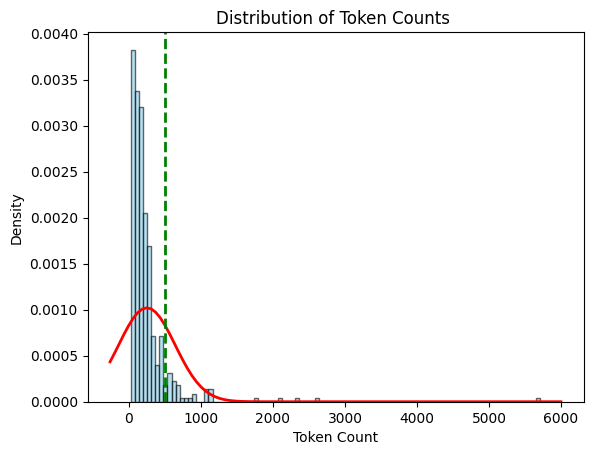

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


# extract values
values = list(articles.values())

# create histogram
plt.hist(values, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# fit a normal distribution
mu, std = norm.fit(values)   # mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)     # probability density function

# plot the fitted bell curve
plt.plot(x, p, 'r', linewidth=2)

plt.axvline(500, color='green', linestyle='--', linewidth=2, label="500 mark")

# labels
plt.title("Distribution of Token Counts ")
plt.xlabel("Token Count")
plt.ylabel("Density")

plt.show()


Since the LLM that will be used late has a input token limit of 512, the entire focus from now will be to contain the token size of the chunks within this limit . Too low, we'll combine them and if higher than the limit ,we'll split them . We can see from above that we have a very high variance in token counts — while many chunks lie well below 512 tokens, a significant number extend far beyond it, even reaching several thousand. This wide spread confirms the need for a systematic merging and splitting strategy to reduce variance and bring chunk sizes closer to the optimal range.

In [41]:
filtered_articles ={}
for item in data :
    if item['token_count'] > 500 :
        filtered_article = list(item.keys())[0]+' ' +item['Article number']
        filtered_articles[filtered_article] = item['token_count']
filtered_articles

{'Article number 15': 574,
 'Article number 16': 550,
 'Article number 19': 669,
 'Article number 22': 609,
 'Article number 31': 1098,
 'Article number 108': 578,
 'Article number 124': 1070,
 'Article number 145': 669,
 'Article number 164': 584,
 'Article number 171': 516,
 'Article number 213': 602,
 'Article number 217': 651,
 'Article number 226': 558,
 'Article number 239': 2099,
 'Article number 243': 2612,
 'Article number 244': 595,
 'Article number 269': 679,
 'Article number 275': 601,
 'Article number 279': 1127,
 'Article number 312': 873,
 'Article number 316': 521,
 'Article number 320': 738,
 'Article number 323': 1124,
 'Article number 330': 536,
 'Article number 332': 894,
 'Article number 334': 501,
 'Article number 338': 2341,
 'Article number 352': 1108,
 'Article number 356': 1056,
 'Article number 359': 640,
 'Article number 360': 524,
 'Article number 361': 895,
 'Article number 366': 1754,
 'Article number 370': 559,
 'Article number 371': 5715,
 'Article numb

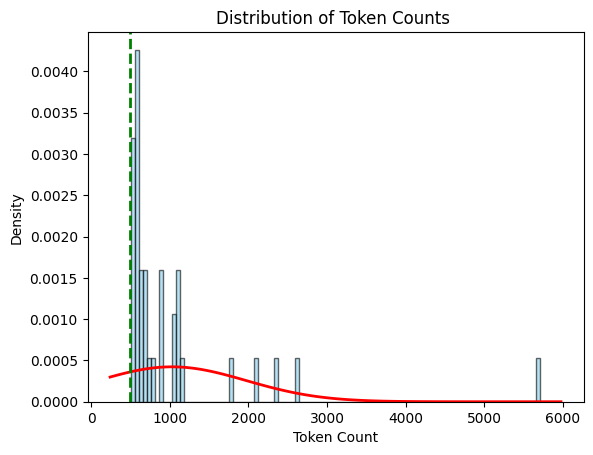

In [42]:

# extract values
values = list(filtered_articles.values())

# create histogram
plt.hist(values, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# fit a normal distribution
mu, std = norm.fit(values)   # mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)     # probability density function

# plot the fitted bell curve
plt.plot(x, p, 'r', linewidth=2)

plt.axvline(500, color='green', linestyle='--', linewidth=2, label="500 mark")

# labels
plt.title("Distribution of Token Counts ")
plt.xlabel("Token Count")
plt.ylabel("Density")

plt.show()


we can see from the plots that the majority of them have token counts less than 500 . since they are broken down as individual articles, we can merge them into groups of articles within a chapter with a much higher token count but less than 500 .

## Chunking

 If the input exceeds the token limit, the model will scrape the extra tokens and this will be a loss of important context . To prevent this , this section explores how we can split the text with token count > 500 further using spacy to be within the token limit.

The strategy here is to identify those chunks with token limit > 500 and split them at the sentence level using spacy(also, there's a fallback of splitting at every ';' if spacy fails)  and combine these sentences into chunks within the token limit.

### Split the larger chunks to less than 500 token count leave the smaller chunks untouched .

In [43]:
from sentence_transformers import SentenceTransformer, util
import spacy

# Initialize models

nlp = spacy.load("en_core_web_sm")  # Load spaCy model for sentence segmentation



def sentence_split(text, max_tokens=500):
    """Split large text into sentence-based chunks <= max_tokens using spaCy, with fallback for very long sentences."""
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]  # Use spaCy for sentence segmentation
    if not sentences:
        return [text]
    
    chunks = []
    current_chunk = []
    current_tokens = 0
    
    for sent in sentences:
        sent_tokens = count_tokens(sent)
        
        # Fallback: If a single sentence exceeds max_tokens, split it on ';'
        if sent_tokens > max_tokens:
            subclauses = [clause.strip() for clause in sent.split(';') if clause]
            #combine the sentences
            for clause in subclauses:
                clause_tokens = count_tokens(clause)
                #if the combination exceeds the token limit, no more combination is possible, append the chunk to the list 
                if current_tokens + clause_tokens > max_tokens and current_chunk:
                    chunks.append(' '.join(current_chunk))
                    current_chunk = []
                    current_tokens = 0
                current_chunk.append(clause)
                current_tokens += clause_tokens
        else:
            if current_tokens + sent_tokens > max_tokens and current_chunk:
                chunks.append(' '.join(current_chunk))
                current_chunk = []
                current_tokens = 0
            
            current_chunk.append(sent)
            current_tokens += sent_tokens
    
    #for any remaining combinations
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks # returns a list of sentences , each with tokens no more than 500.

The function `sentence_split` ensures that all the chunks have their token count within the limit(500) . 

The next function is for merging .The logic is to consider two consecutive chunks as a pair and calculate their combined token count . If the combined token count is less than the token limit, they are merged .If it exceeds the token limit append the first chunk(as it cant be merged anymore) and move on to the next two consecutive chunks. This process repeats till no more consecutive chunks can be merged .  

In [44]:
# Final flat list
final_post_split = []

# for i, d in enumerate(data_merged_without_split):
for i, d in enumerate(data):
    if d['token_count'] > 500:#this is a string 
        splits = sentence_split(d['text'])# this is a a list of strings made by splitting the string
        for j, split_text in enumerate(splits):
            final_post_split.append({
                'text': split_text,
                'section': d['section'],
                'chapter': d['chapter'],
                'token_count': count_tokens(split_text)
            })
    else:
        # Keep the original dict but ensure consistency
        d_copy = d.copy()
        final_post_split.append(d_copy)


In [45]:
final_post_split

[{'Article number': '0',
  'text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'section': 'Preamble',
  'chapter': '0',
  'token_count': 117},
 {'Article number': '1',
  'text': 'PART I\nTHE UNION AND ITS TERRITORY\n1. Name and territory of the Union.—(1) India, that is Bharat, \nshall be a Union of States.\n1[(2) The States and the territories thereof shall be as specified in \nthe First Schedule.]\n(3) The territory of India shall comprise—\

In [46]:
#check the token counts after merging
token_counts= []
for item in final_post_split:
    token_counts.append(item['token_count'])
    # print(item['token_count'])

print(sorted(token_counts,reverse=True))
# print(token_counts)

[497, 487, 486, 483, 482, 482, 481, 480, 480, 480, 478, 477, 475, 473, 473, 471, 471, 470, 470, 469, 468, 468, 466, 466, 466, 466, 465, 465, 464, 463, 462, 461, 459, 459, 457, 457, 457, 455, 454, 454, 453, 451, 450, 450, 448, 448, 448, 448, 447, 446, 446, 445, 444, 444, 443, 441, 439, 436, 436, 436, 435, 432, 432, 431, 430, 429, 428, 427, 426, 424, 424, 423, 420, 420, 419, 419, 419, 418, 417, 416, 415, 414, 413, 410, 407, 407, 404, 402, 402, 400, 399, 398, 392, 385, 383, 377, 365, 364, 364, 363, 355, 353, 353, 350, 350, 347, 346, 342, 342, 337, 335, 333, 333, 332, 332, 331, 330, 325, 323, 322, 319, 317, 315, 314, 312, 311, 309, 306, 304, 304, 303, 301, 301, 300, 300, 299, 296, 296, 295, 292, 292, 291, 291, 290, 290, 288, 287, 287, 286, 286, 285, 285, 283, 279, 279, 278, 276, 275, 272, 271, 268, 268, 266, 264, 264, 263, 263, 261, 257, 255, 254, 254, 253, 252, 252, 251, 249, 249, 249, 248, 247, 247, 246, 245, 244, 243, 242, 240, 239, 238, 234, 234, 230, 229, 228, 228, 227, 227, 225, 224,

In [47]:
len(final_post_split)

486

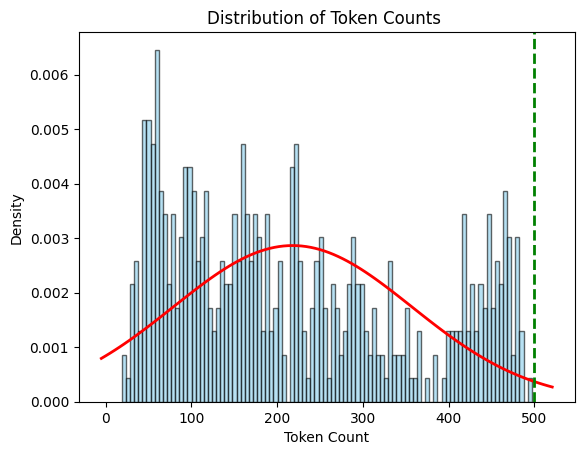

In [48]:
plot_datapoints= {}
for item in final_post_split :
    data_point = item['text']
    plot_datapoints[data_point] = item['token_count']
        


# extract values
values = list(plot_datapoints.values())

# create histogram
plt.hist(values, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# fit a normal distribution
mu, std = norm.fit(values)   # mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)     # probability density function

# plot the fitted bell curve
plt.plot(x, p, 'r', linewidth=2)

plt.axvline(500, color='green', linestyle='--', linewidth=2, label="500 mark")

# labels
plt.title("Distribution of Token Counts ")
plt.xlabel("Token Count")
plt.ylabel("Density")

plt.show()

now, all have token count less than 500  and a lot of these can be merged

In [49]:
def merge_consecutive_pairs(chunks, max_tokens=500):#per chapter
    """Merge consecutive pairs of chunks if their combined token count is < max_tokens. Repeat until no more merges possible. Preserves order."""
    if len(chunks) < 2:
        return chunks

    changed = True
    current_list = chunks[:]

    while changed:
        changed = False
        merged = []
        i = 0
        while i < len(current_list):
            if i == len(current_list) - 1:
                # Last element left as is if odd
                merged.append(current_list[i])
                i += 1
            else:
                first = current_list[i]
                second = current_list[i + 1]
                combined_tokens = first['token_count'] + second['token_count']

                if combined_tokens < max_tokens:
                    # Merge
                    merged_text = first['text'] + ' ' + second['text']
                    merged_dict = {
                        'section': first['section'],
                        'text': merged_text,
                        'token_count': count_tokens(merged_text), # Recalculate for accuracy
                        'chapter' : first['chapter']
                    }
                    merged.append(merged_dict)
                    changed = True
                    i += 2
                else:
                    merged.append(first)
                    i += 1
        current_list = merged
    return current_list

In [50]:
chapter_groups = {}
for item in final_post_split:
    #not all sections have chapters so we skip the ones which have chapter None
    if item['chapter'] != "0":
        chapter_num = item['chapter']
        if chapter_num not in chapter_groups:
            chapter_groups[chapter_num] = []
        chapter_groups[chapter_num].append(item)

chapter_groups


# Now apply chapter-wise article merging
final_chunks_with_chaps = []
for chapter_num, group_list in chapter_groups.items():
    if group_list:
        merged = merge_consecutive_pairs(group_list)
        final_chunks_with_chaps.extend(merged)

# Output or save final_chunks (list of dicts)
print(f"Processed {len(final_chunks_with_chaps)} chunks.")

section_groups = {}
for item in final_post_split:
    #we now conside the ones which have chapter None
    if item['chapter'] == "0":
        section = item['section']
        if section not in section_groups:
            section_groups[section] = []
        section_groups[section].append(item)

# Now apply chapter-wise article merging
final_chunks_without_chaps = []
for section, group_list in section_groups.items():
    if group_list:
        merged = merge_consecutive_pairs(group_list)
        final_chunks_without_chaps.extend(merged)

# Output or save final_chunks (list of dicts)
print(f"Processed {len(final_chunks_without_chaps)} chunks.")

#merge the two lists 
final_post_split_merged = final_chunks_without_chaps + final_chunks_with_chaps
final_post_split_merged

#remove the redundant key
keys = ['Article number' , 'character count']
for key in keys :
    for d in final_post_split_merged:   # your_list = list of dicts
            d.pop(key, None)   # safely remove key if it exists


Processed 156 chunks.
Processed 135 chunks.


In [51]:
#check the token counts after merging
token_counts= []
for item in final_post_split_merged:
    token_counts.append(item['token_count'])

    # print(item['token_count'])

print(sorted(token_counts,reverse=True))
# print(token_counts)

[497, 493, 493, 491, 491, 489, 489, 487, 486, 486, 486, 484, 484, 483, 483, 482, 482, 481, 481, 481, 480, 480, 480, 478, 478, 477, 475, 475, 475, 473, 473, 473, 472, 471, 471, 471, 470, 470, 470, 470, 469, 469, 469, 468, 468, 466, 466, 466, 466, 466, 466, 465, 465, 464, 464, 463, 462, 462, 462, 461, 460, 459, 459, 458, 457, 457, 457, 456, 455, 455, 454, 454, 453, 453, 451, 451, 450, 450, 448, 448, 448, 448, 447, 447, 446, 446, 445, 445, 445, 444, 444, 443, 441, 439, 437, 436, 436, 436, 435, 432, 432, 432, 432, 431, 430, 429, 428, 427, 426, 426, 424, 424, 424, 423, 420, 419, 419, 418, 417, 416, 416, 415, 415, 413, 413, 410, 409, 409, 407, 407, 404, 402, 402, 401, 400, 400, 399, 398, 396, 393, 392, 391, 389, 389, 388, 386, 385, 383, 383, 382, 381, 379, 379, 379, 378, 377, 371, 369, 366, 365, 364, 364, 364, 362, 361, 361, 357, 357, 355, 353, 351, 351, 351, 350, 350, 343, 342, 342, 342, 342, 342, 337, 337, 335, 335, 333, 332, 332, 332, 331, 327, 325, 322, 321, 320, 319, 319, 318, 314, 312,

In [52]:
print(token_counts)

[117, 186, 455, 343, 475, 314, 378, 230, 402, 332, 482, 371, 466, 243, 409, 255, 389, 428, 446, 415, 379, 97, 432, 342, 234, 291, 291, 465, 480, 392, 466, 304, 350, 271, 420, 407, 448, 473, 337, 459, 426, 468, 104, 470, 450, 457, 332, 364, 453, 429, 218, 436, 177, 444, 482, 481, 471, 457, 287, 471, 126, 445, 240, 483, 295, 350, 464, 466, 192, 480, 123, 419, 477, 78, 436, 216, 409, 486, 475, 407, 333, 423, 383, 388, 444, 480, 377, 255, 478, 497, 353, 193, 335, 342, 385, 257, 364, 162, 419, 478, 49, 468, 318, 435, 288, 319, 355, 365, 215, 465, 325, 466, 95, 441, 466, 224, 417, 473, 461, 322, 463, 424, 445, 455, 450, 383, 301, 459, 430, 493, 432, 416, 415, 437, 401, 255, 424, 212, 369, 432, 177, 357, 486, 256, 262, 472, 483, 469, 309, 427, 418, 460, 484, 300, 364, 311, 254, 264, 410, 362, 426, 300, 249, 331, 311, 448, 184, 436, 382, 290, 285, 462, 451, 279, 402, 454, 381, 287, 243, 292, 396, 443, 351, 386, 481, 451, 486, 100, 400, 293, 40, 292, 288, 445, 177, 446, 295, 327, 357, 448, 457,

In [53]:
final_post_split_merged

[{'text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'section': 'Preamble',
  'chapter': '0',
  'token_count': 117},
 {'section': 'Part I.—Union and its territory',
  'text': 'PART I\nTHE UNION AND ITS TERRITORY\n1. Name and territory of the Union.—(1) India, that is Bharat, \nshall be a Union of States.\n1[(2) The States and the territories thereof shall be as specified in \nthe First Schedule.]\n(3) The territory of India shall comprise—\n(

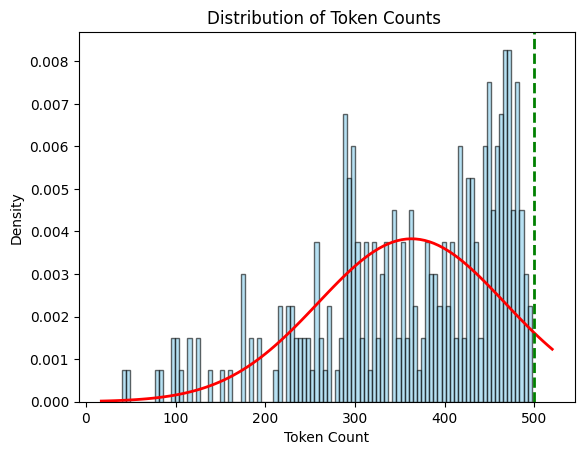

In [54]:
plot_datapoints= {}
for item in final_post_split_merged :
    data_point = item['text']
    plot_datapoints[data_point] = item['token_count']
        


# extract values
values = list(plot_datapoints.values())

# create histogram
plt.hist(values, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# fit a normal distribution
mu, std = norm.fit(values)   # mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)     # probability density function

# plot the fitted bell curve
plt.plot(x, p, 'r', linewidth=2)

plt.axvline(500, color='green', linestyle='--', linewidth=2, label="500 mark")

# labels
plt.title("Distribution of Token Counts ")
plt.xlabel("Token Count")
plt.ylabel("Density")

plt.show()

## Final data

In [55]:
final_data = final_post_split_merged

In [56]:
#check the token counts after merging
token_counts= []
for item in final_data:
    token_counts.append(item['token_count'])
    # print(item['token_count'])
current_split = sorted(token_counts,reverse=True)
print(current_split)
# print(token_counts)

[497, 493, 493, 491, 491, 489, 489, 487, 486, 486, 486, 484, 484, 483, 483, 482, 482, 481, 481, 481, 480, 480, 480, 478, 478, 477, 475, 475, 475, 473, 473, 473, 472, 471, 471, 471, 470, 470, 470, 470, 469, 469, 469, 468, 468, 466, 466, 466, 466, 466, 466, 465, 465, 464, 464, 463, 462, 462, 462, 461, 460, 459, 459, 458, 457, 457, 457, 456, 455, 455, 454, 454, 453, 453, 451, 451, 450, 450, 448, 448, 448, 448, 447, 447, 446, 446, 445, 445, 445, 444, 444, 443, 441, 439, 437, 436, 436, 436, 435, 432, 432, 432, 432, 431, 430, 429, 428, 427, 426, 426, 424, 424, 424, 423, 420, 419, 419, 418, 417, 416, 416, 415, 415, 413, 413, 410, 409, 409, 407, 407, 404, 402, 402, 401, 400, 400, 399, 398, 396, 393, 392, 391, 389, 389, 388, 386, 385, 383, 383, 382, 381, 379, 379, 379, 378, 377, 371, 369, 366, 365, 364, 364, 364, 362, 361, 361, 357, 357, 355, 353, 351, 351, 351, 350, 350, 343, 342, 342, 342, 342, 342, 337, 337, 335, 335, 333, 332, 332, 332, 331, 327, 325, 322, 321, 320, 319, 319, 318, 314, 312,

# Embedding

In [142]:
from sentence_transformers import SentenceTransformer

#i want the model to take 512 i/p tokens
model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
print(model.max_seq_length)  # should print 512


512


In [143]:
#test
single_sentence = "This is all about the Constitution of India"
single_embedding = model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: This is all about the Constitution of India
Embedding:
[-2.29484830e-02 -2.45491236e-01 -3.11872065e-01  2.16670521e-02
 -1.54332012e-01 -1.99742511e-01 -6.04186468e-02  1.80677891e-01
  2.79928893e-02  2.46636689e-01  1.54098451e-01 -3.19196880e-02
 -1.36623830e-01 -9.63766575e-02 -9.26898047e-02 -1.76163048e-01
  2.06278730e-02  3.02298844e-01 -5.07820770e-02  2.18498975e-01
 -1.75143689e-01 -8.95166770e-02 -3.94101292e-01 -4.48018424e-02
 -9.99091864e-02  1.76205620e-01  4.89420667e-02  3.98150645e-02
 -5.03560424e-01 -3.29972282e-02 -1.54742390e-01  9.80406851e-02
 -2.03792788e-02  1.48961589e-01 -8.70389849e-05 -3.25626671e-01
  2.79523402e-01 -2.99932377e-04 -5.36121167e-02  4.33210701e-01
 -2.36821994e-01  2.06530556e-01 -1.66841462e-01 -1.54242843e-01
 -2.46435657e-01  3.18585604e-01  9.69067588e-02  3.91057581e-02
 -4.47298996e-02  4.38098162e-01  4.29562360e-01 -9.93022174e-02
  1.63305834e-01 -3.36457372e-01 -3.23791020e-02  1.70630679e-01
 -1.15379514e-02 -1.10061

we'll be using pytorch to store the embedded data instead of vector database as our data is small and can be managed with pytorch .

My version install : pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu129

In [144]:
%%time
import torch
# Send the model to the GPU
model.to("cuda") 

# Create embeddings one by one on the GPU - by looping
for item in final_data:
    item["embedding"] = model.encode(item["text"],
                                     normalize_embeddings=True,     # important for cosine/dot
                                     )

CPU times: total: 1min 31s
Wall time: 11.6 s


In [145]:
final_data[:5]

[{'text': 'PREAMBLE\nWE, THE PEOPLE OF INDIA, having solemnly resolved to constitute \nIndia into a \n1[SOVEREIGN SOCIALIST SECULAR DEMOCRATIC \nREPUBLIC] and to secure to all its citizens:\nJUSTICE, social, economic and political;\n \nLIBERTY of thought, expression, belief, faith and worship;\nEQUALITY of status and of opportunity;\nand to promote among them all\nFRATERNITY assuring the dignity of the individual and the 2[unity \nand integrity of the Nation];\nIN OUR CONSTITUENT ASSEMBLY this twenty-sixth day of \nNovember, 1949, do HEREBY ADOPT, ENACT AND GIVE TO \nOURSELVES THIS CONSTITUTION.',
  'section': 'Preamble',
  'chapter': '0',
  'token_count': 117,
  'embedding': array([-5.40214172e-03, -8.24730750e-03, -2.30496284e-02,  3.61744650e-02,
          1.00562628e-02, -1.62040200e-02, -3.78147252e-02,  4.63577993e-02,
         -8.88304599e-03,  4.80405055e-02,  3.29456180e-02,  2.14816816e-02,
         -1.38736218e-02, -4.64618914e-02, -1.72602385e-02, -5.42929359e-02,
         

In [147]:
%%time

#faster embedding while done as batches
# Turn text chunks into a single list => this is a list of all sentence chunks
text_chunks = [item["text"] for item in final_data]



# Embed all texts in batches
text_chunk_embeddings = model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True,
                                               normalize_embeddings=True,     # important for cosine/dot
                                                ) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 24.7 s
Wall time: 11.7 s


tensor([[-0.0054, -0.0082, -0.0230,  ..., -0.0482, -0.0429, -0.0089],
        [ 0.0012, -0.0688, -0.0184,  ..., -0.0519, -0.0084, -0.0046],
        [ 0.0099, -0.0104, -0.0212,  ..., -0.0596, -0.0965, -0.0092],
        ...,
        [ 0.0567, -0.0035, -0.0299,  ..., -0.0434, -0.1017, -0.0106],
        [ 0.0140,  0.0067, -0.0173,  ..., -0.0034, -0.0637, -0.0049],
        [ 0.0217, -0.0331, -0.0298,  ..., -0.0090, -0.0455, -0.0326]],
       device='cuda:0')

## Saving Embeddings to a file

In [ ]:
import pandas as pd
# Save embeddings to file
embeddings_df = pd.DataFrame(final_data)
save_path = "constitution_embeddings.csv"
embeddings_df.to_csv(save_path, index=False)

In [149]:
embeddings_df[:3]

,text,section,chapter,token_count,embedding
0,"PREAMBLE\nWE, THE PEOPLE OF INDIA, having sole...",Preamble,0,117,"[-0.0054021417, -0.0082473075, -0.023049628, 0..."
1,PART I\nTHE UNION AND ITS TERRITORY\n1. Name a...,Part I.—Union and its territory,0,186,"[0.0011703587, -0.068806894, -0.018350646, 0.0..."
2,3. Formation of new States and alteration of a...,Part I.—Union and its territory,0,455,"[0.009856809, -0.010368085, -0.021209022, 0.02..."


In [150]:
# Import saved file and view
constitution = pd.read_csv(save_path)
constitution.head()

,text,section,chapter,token_count,embedding
0,"PREAMBLE\nWE, THE PEOPLE OF INDIA, having sole...",Preamble,0,117,[-5.40214172e-03 -8.24730750e-03 -2.30496284e-...
1,PART I\nTHE UNION AND ITS TERRITORY\n1. Name a...,Part I.—Union and its territory,0,186,[ 1.17035874e-03 -6.88068941e-02 -1.83506459e-...
2,3. Formation of new States and alteration of a...,Part I.—Union and its territory,0,455,[ 9.85680893e-03 -1.03680845e-02 -2.12090220e-...
3,PART II\nCITIZENSHIP\n5. Citizenship at the co...,Part II.—Citizenship,0,343,[-9.39577073e-03 1.01611437e-02 -1.81463622e-...
4,7. Rights of citizenship of certain migrants t...,Part II.—Citizenship,0,475,[-2.75272480e-03 3.07379779e-03 -1.64747369e-...


### The end of data preprocessing !

## Further improvements :

- can use semantic splitting at the sentence level with overlap 